In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, count, when, mean, hour, dayofweek, sum
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, TimestampType
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("TaxiAnalyse").getOrCreate()

In [3]:
# Load data
file_path = r"/backend/uploads/yellow_tripdata_2024-01.parquet"
df_spark = spark.read.parquet(file_path, header=True, inferSchema=True)

In [4]:
df_spark.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|           2|       17.7|  1.0|    0.5|       0.

In [5]:
df_spark.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [6]:
# Check for null values in each column
null_counts = df_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns])
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|         140162|            0|    140162|            140162|           0|           0|           0|          0|    0|      0|         

In [7]:
# Statistics
df_spark.summary().show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+
|summary|          VendorID|   passenger_count|     trip_distance|       RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+----

In [8]:
# Remplir les valeurs manquantes
df_spark = df_spark.fillna({
    "RatecodeID": 1,
    "store_and_fwd_flag": "N",  # Vous pouvez choisir soit "N" soit "Y"
    "congestion_surcharge": 2.5,
    "Airport_fee": 0
})

In [9]:
# Remplacer les valeurs manquantes de `passenger_count` par la moyenne
mean_passenger_count = df_spark.select(mean(col("passenger_count"))).collect()[0][0]
df_spark = df_spark.fillna({"passenger_count": mean_passenger_count})

In [10]:
# Filtrer les trajets aberrants (prix < 2$ ou distance < 0.5 km)
df_spark = df_spark.filter((col("fare_amount") >= 2) & (col("trip_distance") >= 0.5))

In [11]:
# Convertir les colonnes de date si nécessaire
df_spark = df_spark.withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast("timestamp"))
df_spark = df_spark.withColumn("tpep_dropoff_datetime", col("tpep_dropoff_datetime").cast("timestamp"))

In [12]:
# Check for null values in each column
null_counts = df_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns])
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

In [13]:
df_spark = df_spark.withColumn("hour", hour(col("tpep_pickup_datetime")))
df_spark = df_spark.withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))

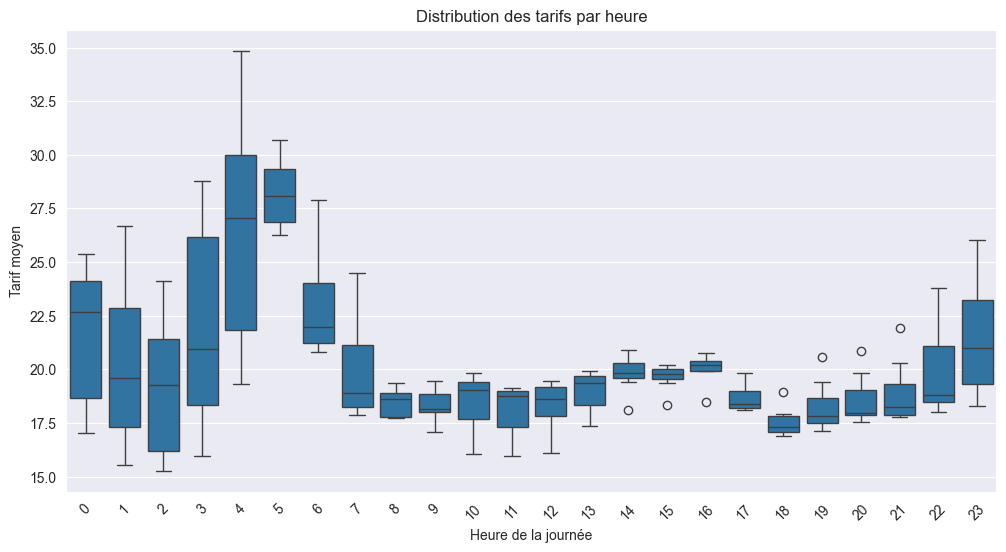

In [14]:
# We can know the average fare for each hour of the day .
df_agg = df_spark.groupBy("hour", "day_of_week").agg(mean("fare_amount").alias("avg_fare"))

# Identifier les heures de pointe
df_peak = df_agg.orderBy(col("avg_fare").desc())

df_pandas = df_agg.toPandas()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df_pandas["hour"], y=df_pandas["avg_fare"])
plt.xlabel("Heure de la journée")
plt.ylabel("Tarif moyen")
plt.title("Distribution des tarifs par heure")
plt.xticks(rotation=45)
plt.show()

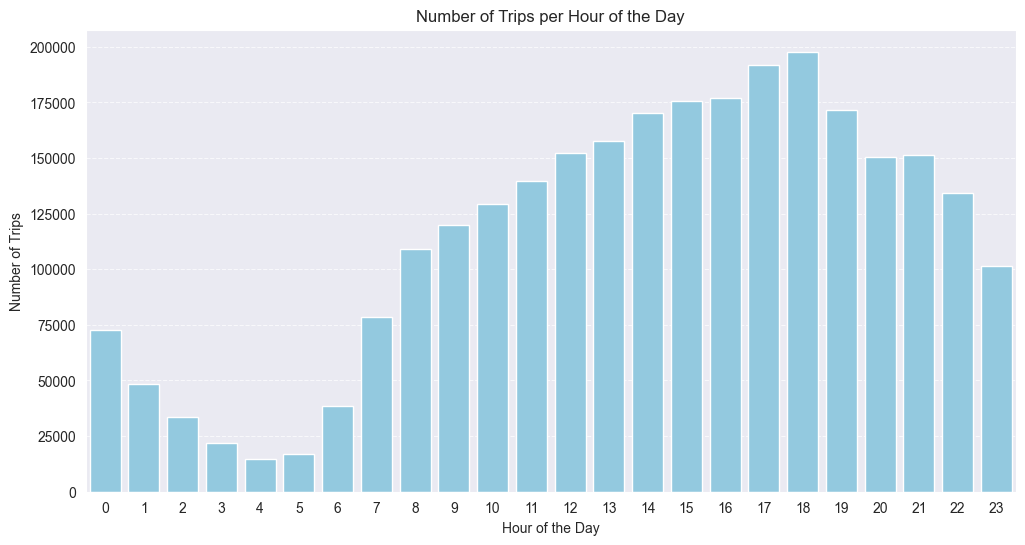

In [15]:
# We can know the hour when there are the most trips during the day.
df_spark = df_spark.withColumn("hour", hour(col("tpep_pickup_datetime")))

df_trips = df_spark.groupBy("hour").count().orderBy("hour")

df_pandas = df_trips.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="hour", y="count", data=df_pandas, color='skyblue')

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.title("Number of Trips per Hour of the Day")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [16]:
# We can see that even if the tax in 5 a.m is the highest one but it does not mean that is the most hour that taxis work in.
# If we want to know the best profitable hour in the day we do some small calculations,we multiply the number of trips by the price of the tax or to be more accurate we count the total revenue by adding on the fare amount.

In [17]:
df_spark = df_spark.withColumn("fare_amount", col("fare_amount").cast("float"))

df_spark = df_spark.withColumn("hour", hour(col("tpep_pickup_datetime")))

df_revenue = df_spark.groupBy("hour").agg(
    sum(col("fare_amount")).alias("total_revenue"),
    count(col("fare_amount")).alias("count")
)

df_pandas = df_revenue.toPandas()

best_hour = df_pandas.loc[df_pandas["total_revenue"].idxmax()]

print(f"The best hour of the day for payment is {best_hour['hour']:.0f} with a total revenue of {best_hour['total_revenue']:.0f} $ .")

The best hour of the day for payment is 17 with a total revenue of 3570427 $ .
